In [1]:
import requests
import pandas as pd
import time
import json
from scipy import spatial
import matplotlib
%matplotlib inline
from IPython.display import display, Image
from neo4j import GraphDatabase
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
#import nltk
#nltk.download() 
#download wordnet corpus

class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response
    
conn = Neo4jConnection(uri="bolt://localhost:7687", user="neo4j", pwd="miriam")

In [3]:
#open data from google vision

search_connection_array = {}

with open('data.json', encoding='utf8') as json_file:
    data = json.load(json_file)
    for p in data:
        img_id = p['_source']['Image path'].replace("C:\\Users\\user\\Desktop\\images\\unsplash\\","")
        #print(img_id)
        search_connection_array[img_id] = []
        temp = {}
        for d in p['_source']['labelAnnotations']:
            temp[str(d['description']).replace(" ","_").replace("-","_").lower()] = d['score']
            #print(d['description'])
        search_connection_array[img_id].append(temp)
        #print()

        
print(list(search_connection_array.items())[0][1]) 
print(list(list(search_connection_array.items())[0][1][0]))
print(list(list(search_connection_array.items())[0][1][0].values()))
#print(search_connection_array[0])


[{'beach': 0.91019934, 'sea': 0.90897596, 'mode_of_transport': 0.8827981, 'ocean': 0.8277209, 'tourism': 0.823462, 'sky': 0.8220895, 'vacation': 0.8189033, 'shore': 0.7701214, 'vehicle': 0.75180185, 'leisure': 0.70920753}]
['beach', 'sea', 'mode_of_transport', 'ocean', 'tourism', 'sky', 'vacation', 'shore', 'vehicle', 'leisure']
[0.91019934, 0.90897596, 0.8827981, 0.8277209, 0.823462, 0.8220895, 0.8189033, 0.7701214, 0.75180185, 0.70920753]


In [2]:
with open('conceptnetarrayAllFinal.json', encoding='utf8') as json_file:
    conceptnet_array = json.load(json_file)
    
print(len(conceptnet_array)) 

10210


In [5]:
class ConceptNet2Neo4j:

    def __init__(self, neo4jconn, conceptnet_array={}):
        self.__neo4jconn = neo4jconn
        self.__conceptnet_array = conceptnet_array
        self.__lang = "en"
        self.__cache_counter = 0
        self.__get_counter = 0
        self.__numberbatchpath = 'C:\\Users\\HP\\Desktop\\conceptnet\\numberbatch-en.txt'
        
    def getCacheCounter(self) :
        return  self.__cache_counter
    
    def getGetCounter(self) :
        return  self.__get_counter
    
    def resetCacheCounter(self) :
        self.__cache_counter = 0
    
    def resetGetCounter(self) :
        self.__get_counter = 0
        
    def requestsGet(self, url) :
        
        try:
            r = requests.get(url)
            r.raise_for_status()
            
        except requests.exceptions.HTTPError as e:
            raise SystemExit(e)   
            
        except requests.exceptions.RequestException as e:
            raise SystemExit(e)
        
       
        return r
    
    def checkSynonym(self, word1, word2) :
        
        url_search = "http://api.conceptnet.io/query?node=/c/" +self.__lang+'/'+word1+'&other=/c/'+self.__lang+'/'+word2
                    
        obj = self.requestsGet(url_search).json()
        
        
    
    def createGraph(self, words_array, multipredicat = False):
        
        search_connection = words_array

        escape_string = "/"
        
        if multipredicat :
            mp_query_start = ""
            mp_query_end = ""
        else :
            mp_query_start = " FOREACH(ignoreme in CASE WHEN NOT EXISTS( (w)--(w2)) THEN [1] ELSE [] END | "
            mp_query_end = ")"

        resert_query = "MATCH (n) DETACH DELETE n"
        result = self.__neo4jconn.query(resert_query)

        i = 0

        while i < len(search_connection) :
            j= i + 1

            string_query = "MERGE (w:word{id: '"+search_connection[i].replace("'","\\'")+"'}) ON MATCH SET w.kind = 'original' ON CREATE SET w.kind = 'original'"
            result = self.__neo4jconn.query(string_query) 
            while j < len(search_connection) :
                #print(search_connection[i] + "=>"+search_connection[j])
                conceptnet_result = {}
                if search_connection[i]+"<=>"+search_connection[j] in self.__conceptnet_array :
                    #print(search_connection[i]+"<=>"+search_connection[j]+" found in cache")
                    conceptnet_result = self.__conceptnet_array[search_connection[i]+"<=>"+search_connection[j]]
                    self.__cache_counter += 1

                else :
                    self.__get_counter += 1
                    
                    url_search = "http://api.conceptnet.io/query?node=/c/" +self.__lang+'/'+search_connection[i]+'&other=/c/'+self.__lang+'/'+search_connection[j]
                    
                    obj = self.requestsGet(url_search).json()

                    if len(obj['edges']) > 0 :
                        conceptnet_result = obj['edges'][0]
                        self.__conceptnet_array[search_connection[i]+"<=>"+search_connection[j]] = obj['edges'][0]
                    else :
                        self.__conceptnet_array[search_connection[i]+"<=>"+search_connection[j]] = []

                if len(conceptnet_result) > 0 :
                    if conceptnet_result["end"]["label"] == search_connection[i] :
                        string_query = "MERGE (w:word{id: '"+search_connection[i].replace("'","\\'")+"'}) MERGE (w2:word{id: '"+search_connection[j].replace("'","\\'")+"'}) "+mp_query_start+" MERGE (w)<-[: "+conceptnet_result['rel']['label']+" ]-(w2)"+mp_query_end

                    else :
                        string_query = "MERGE (w:word{id: '"+search_connection[i].replace("'","\\'")+"'}) MERGE (w2:word{id: '"+search_connection[j].replace("'","\\'")+"'}) "+mp_query_start+" MERGE (w)-[: "+conceptnet_result['rel']['label']+" ]->(w2)"+mp_query_end

                  
                    result = self.__neo4jconn.query(string_query) 

                conceptnet_result.clear()
                related1 = []
                related2 = []


                if search_connection[i] in self.__conceptnet_array :

                    #print(search_connection[i]+" found in cache")
                    obj_extend1 = self.__conceptnet_array[search_connection[i]]
                    self.__cache_counter += 1

                else :
                    self.__get_counter += 1  
                    
                    url_extend_search1 = "http://api.conceptnet.io/query?node=/c/" +self.__lang+'/'+search_connection[i]+'&other=/c/'+self.__lang+'&offset=0&limit=1000'
                    obj_extend1 = self.__conceptnet_array[search_connection[i]] =  self.requestsGet(url_extend_search1).json()
                    


                #print(url_extend_search1)
                if len(obj_extend1['edges']) > 0 :
                    for obj_extend1_edges in obj_extend1['edges'] :
                        if obj_extend1_edges["end"]["label"] == search_connection[i] :
                            related1_clean = obj_extend1_edges["start"]["@id"].replace("/c/"+self.__lang+"/","")
                            related1_direction = 2
                          
                        else :
                            related1_clean = obj_extend1_edges["end"]["@id"].replace("/c/"+self.__lang+"/","")
                            related1_direction = 1

                        rel_value = obj_extend1_edges["rel"]["label"]
                        if escape_string not in related1_clean :
                            related1.append([related1_clean,related1_direction,rel_value])

                if search_connection[j] in self.__conceptnet_array :
                    #print(search_connection[j]+" found in cache")
                    obj_extend2 = self.__conceptnet_array[search_connection[j]]
                    self.__cache_counter += 1

                else :
                    self.__get_counter += 1
                    
                    url_extend_search2 = "http://api.conceptnet.io/query?node=/c/" +self.__lang+'/'+search_connection[j]+'&other=/c/'+self.__lang+'&offset=0&limit=1000'
                    obj_extend2 = self.__conceptnet_array[search_connection[j]] = self.requestsGet(url_extend_search2).json()
                    


                if len(obj_extend2['edges']) > 0 :
                    for obj_extend2_edges in obj_extend2['edges'] :
                        if obj_extend2_edges["end"]["label"] == search_connection[j] :
                            related2_clean = obj_extend2_edges["start"]["@id"].replace("/c/"+self.__lang+"/","")
                            related2_direction = 2
                        else :
                            related2_clean = obj_extend2_edges["end"]["@id"].replace("/c/"+self.__lang+"/","")
                            related2_direction = 1

                        rel_value = obj_extend2_edges["rel"]["label"]
                        if escape_string not in related2_clean :   
                            related2.append([related2_clean,related2_direction,rel_value])    


                df1 = pd.DataFrame(related1,columns=['node','direction1','relation1'])
                df2 = pd.DataFrame(related2,columns=['node','direction2','relation2'])
            
                related1.clear()
                related2.clear()

                df1 = df1.merge(df2,how="outer" ,on=['node'])
                df1 = df1.dropna()
                
                if ~multipredicat :
                    df1 = df1.drop_duplicates(subset ="node")

                for row in df1.itertuples() :
                    if search_connection[i] != row.node :
                        if row.direction1 == 1 :
                            string_query = "MERGE (w:word{id: '"+search_connection[i].replace("'","\\'")+"'}) MERGE (w2:word{id: '"+row.node.replace("'","\\'")+"'}) "+mp_query_start+" MERGE (w)-[: "+row.relation1+" ]->(w2)"+mp_query_end   

                        else :
                            string_query = "MERGE (w:word{id: '"+search_connection[i].replace("'","\\'")+"'}) MERGE (w2:word{id: '"+row.node.replace("'","\\'")+"'}) "+mp_query_start+" MERGE (w)<-[: "+row.relation1+" ]-(w2)"+mp_query_end   

                        result = self.__neo4jconn.query(string_query)

                    if search_connection[j] != row.node : 
                        if row.direction2 == 1 :
                            string_query = "MERGE (w:word{id: '"+search_connection[j].replace("'","\\'")+"'}) MERGE (w2:word{id: '"+row.node.replace("'","\\'")+"'}) "+mp_query_start+" MERGE (w)-[: "+row.relation2+" ]->(w2)"+mp_query_end

                        else :
                            string_query = "MERGE (w:word{id: '"+search_connection[j].replace("'","\\'")+"'}) MERGE (w2:word{id: '"+row.node.replace("'","\\'")+"'}) "+mp_query_start+" MERGE (w)<-[: "+row.relation2+" ]-(w2)"+mp_query_end
                        
                        
                        
                        result = self.__neo4jconn.query(string_query)    

                j+=1
            i+=1
        
        
        first_node_query = "MATCH (n:word) WITH DISTINCT n.kind AS kind, collect(DISTINCT n) AS words call apoc.create.addLabels(words,[kind]) yield node RETURN *"
        result = self.__neo4jconn.query(first_node_query)
        return True
    
    def filterByConnections(self, onlyBOW=False, order = True, limit = -1, minConnection = 0):
        
        master_query = ""
        limit_query = ""
        
        
        if onlyBOW :
            master_query = "{kind: 'original'}"
                
        if order :
            max_query = "DESC"
        else :
            max_query = "ASC"
        
        if limit > 0 :
            limit_query = " LIMIT "+str(limit)
        
        string_query = "MATCH (w:word) WITH w, SIZE((:word "+master_query+" )--(w)) as wordcnt ORDER BY wordcnt "+max_query+" RETURN w.id, wordcnt"+limit_query
        
        result = self.__neo4jconn.query(string_query) 

        connected_words = {}

        for res in result :
            if int(res["wordcnt"]) >= minConnection :
                connected_words[res["w.id"]] = res["wordcnt"]

        return connected_words
    
    def getRelationshipCount(self) :
        
        string_query = "MATCH ()-[r]-() RETURN count(*) as count"
        
        
        result = self.__neo4jconn.query(string_query) 
        
        return int(int(result[0]["count"])/2)
    
    def resultWithoutOriginals(self, originals_words, results_words):
        clean_result = []
      
        for mnc in results_words :
            if mnc not in originals_words :
                clean_result.append(mnc)
           
       
        return clean_result
    
    def getVectorsFromWords(self, original_words, result_words):
         
        original_words_lenght = len(original_words)
        result_words_lenght = len(result_words)
        original_words_vectors = []
        result_words_vectors = []
        
        with open(self.__numberbatchpath , 'rb') as fileobject:
            #for line in islice(fileobject, start, None):
            for line in fileobject:
                li = list(line.decode().replace("\n", "").split(" ")) 
               
                if li[0] in original_words : 
                    original_words_vectors.append(li)
                  
                    if len(original_words_vectors) == original_words_lenght and len(result_words_vectors) == result_words_lenght:
                        break

                if li[0] in result_words :
                    result_words_vectors.append(li)
                   
                    if len(original_words_vectors) == original_words_lenght and len(result_words_vectors) == result_words_lenght:
                        break    
                
        return original_words_vectors , result_words_vectors 
    
    def colorSelectedOnGraph(self, words ) :
        
        words = ["'{0}'".format(word.replace("'","\\'")) for word in words]
        
        word_array_string = ","
        word_array_string = word_array_string.join(words)
            
        string_query = "MATCH (w:word) WHERE w.id IN ["+word_array_string+"] SET w.filter = 'cosine'"
        result = self.__neo4jconn.query(string_query) 
        
        create_label_query = "MATCH (n:word) WITH DISTINCT n.filter AS cosine, collect(DISTINCT n) AS words call apoc.create.addLabels(words,[cosine]) yield node RETURN *"
        result = self.__neo4jconn.query(create_label_query)
       
       # print(string_query) 
       # print(create_label_query) 

        
    def cosineSimilarity(self, original_words_vectors, result_words__vectors ,  cosine_min = 0.5 ) :
        filtred_words = []

        for origin in original_words_vectors :
            for result in result_words__vectors :
                cosine = 1 - spatial.distance.cosine([float(i) for i in result[1:]], [float(i) for i in origin[1:]])
                if cosine > cosine_min :
                    #print("Cosine Similarity : "+origin[0]+" <-> "+result[0]+" = "+str(cosine))
                    if result[0] not in filtred_words :
                        filtred_words.append(result[0])


        filtred_words.sort()
        return filtred_words
    
    def calculateCosineSimilarity(self, original_words_vectors, result_words__vectors ,  cosine_min = 0.5 ) :
        filtred_words = {}

        for origin in original_words_vectors :
            for result in result_words__vectors :
                cosine = 1 - spatial.distance.cosine([float(i) for i in result[1:]], [float(i) for i in origin[1:]])
                if cosine > cosine_min :
                    #print("Cosine Similarity : "+origin[0]+" <-> "+result[0]+" = "+str(cosine))
                    if result[0] not in filtred_words :
                        filtred_words[result[0]] = cosine
                    else :
                        if filtred_words[result[0]] < cosine :
                            filtred_words[result[0]] = cosine


        #filtred_words.sort()
        return filtred_words
    
    def calculatePageRank(self, node_type = "'word'") :
        
        string_query = "CALL gds.graph.create('my-graph', "+node_type+", '*') YIELD graphName, nodeCount, relationshipCount;"
        self.__neo4jconn.query(string_query) 
        
        string_query = "CALL gds.pageRank.stream('my-graph') YIELD nodeId, score RETURN gds.util.asNode(nodeId).id AS name, score ORDER BY score DESC, name ASC"
        result = self.__neo4jconn.query(string_query)   
    
        string_query = "CALL gds.graph.drop('my-graph')"
        self.__neo4jconn.query(string_query) 
        
        results_array = {}
        
        

        for res in result :
            results_array[res["name"]] = res["score"]

        return results_array
    
    def calculateBetweenessCentrality(self, node_type = "word") :
        
        string_query = "CALL gds.graph.create('my-graph', '"+node_type+"', '*') YIELD graphName, nodeCount, relationshipCount;"
        self.__neo4jconn.query(string_query) 
        
        string_query = "CALL gds.betweenness.stream('my-graph') YIELD nodeId, score RETURN gds.util.asNode(nodeId).id AS name, score ORDER BY score DESC, name ASC"
        result = self.__neo4jconn.query(string_query)   
    
        string_query = "CALL gds.graph.drop('my-graph')"
        self.__neo4jconn.query(string_query) 
        
        results_array = {}
        
        #print(result)
            
        for res in result :
            results_array[res["name"]] = res["score"]

        return results_array
    
      
    def stemmingFiltered(self, words) :
        
        stemmed = []
      
        ps = PorterStemmer() 

        for w in words:
            stemmed.append(ps.stem(w))

        return stemmed
    
    def lemmatizationFiltered(self, words) :
        
        lemmatized = []
       
        lemmatizer = WordNetLemmatizer() 
        
        for w in words:
            lemmatized.append(lemmatizer.lemmatize(w))
        
        return lemmatized
        

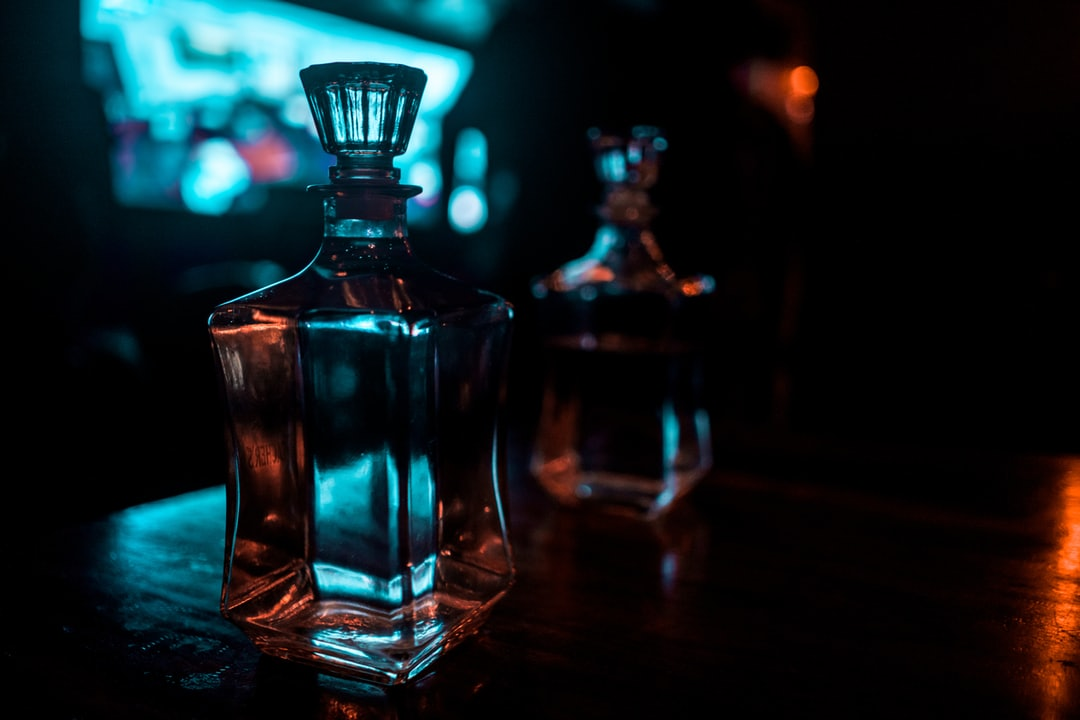

-z-WEOD0AdI.jpg
3.2040295600891113 seconds for create graph


,PageRankRed,PageRankBlue,PageRankGreen,Betweenness,Min 3 connections,Cosine Similarity
alcohol,0.451062,2.053290,2.056061,672.564286,NaN,NaN
light,0.405000,1.208040,0.752794,757.233333,NaN,NaN
bottle,0.391848,1.109290,0.556804,797.230952,3.0,NaN
drink,0.316535,2.821244,1.999119,2528.083333,3.0,NaN
glass,0.284527,1.678406,1.635318,2810.083333,NaN,NaN
barware,0.150000,0.150000,0.150000,0.000000,NaN,NaN
blue,0.150000,0.436094,0.361892,1039.152381,NaN,NaN
darkness,0.150000,0.221252,0.150000,122.233333,NaN,NaN
glass_bottle,0.150000,0.150000,0.150000,0.000000,NaN,NaN
liqueur,0.150000,0.192500,0.192500,2.666667,NaN,NaN


,PageRankRed,PageRankBlue,PageRankGreen,Betweenness,Min 3 connections,Cosine Similarity
drink,0.316535,2.821244,1.999119,2528.083333,3.0,NaN
alcohol,0.451062,2.053290,2.056061,672.564286,NaN,NaN
glass,0.284527,1.678406,1.635318,2810.083333,NaN,NaN
light,0.405000,1.208040,0.752794,757.233333,NaN,NaN
bottle,0.391848,1.109290,0.556804,797.230952,3.0,NaN
liquid,NaN,0.471116,NaN,0.000000,5.0,NaN
beer,NaN,0.444311,0.697209,0.000000,4.0,0.646897
blue,0.150000,0.436094,0.361892,1039.152381,NaN,NaN
fridge,NaN,0.429555,NaN,0.000000,3.0,NaN
beverage,NaN,0.403106,0.675445,399.533333,4.0,0.842928


,PageRankRed,PageRankBlue,PageRankGreen,Betweenness,Min 3 connections,Cosine Similarity
alcohol,0.451062,2.053290,2.056061,672.564286,NaN,NaN
drink,0.316535,2.821244,1.999119,2528.083333,3.0,NaN
glass,0.284527,1.678406,1.635318,2810.083333,NaN,NaN
colour,NaN,0.270335,0.851395,0.000000,NaN,0.567363
light,0.405000,1.208040,0.752794,757.233333,NaN,NaN
beer,NaN,0.444311,0.697209,0.000000,4.0,0.646897
beverage,NaN,0.403106,0.675445,399.533333,4.0,0.842928
drinks,NaN,0.363452,0.632621,86.166667,4.0,0.872136
intoxication,NaN,0.370381,0.620903,0.000000,NaN,0.647368
bottle,0.391848,1.109290,0.556804,797.230952,3.0,NaN


,PageRankRed,PageRankBlue,PageRankGreen,Betweenness,Min 3 connections,Cosine Similarity
glass,0.284527,1.678406,1.635318,2810.083333,NaN,NaN
drink,0.316535,2.821244,1.999119,2528.083333,3.0,NaN
blue,0.150000,0.436094,0.361892,1039.152381,NaN,NaN
green,NaN,0.186581,0.249287,921.619048,NaN,0.649264
bottle,0.391848,1.109290,0.556804,797.230952,3.0,NaN
light,0.405000,1.208040,0.752794,757.233333,NaN,NaN
alcohol,0.451062,2.053290,2.056061,672.564286,NaN,NaN
case,NaN,0.252683,NaN,402.200000,NaN,NaN
beverage,NaN,0.403106,0.675445,399.533333,4.0,0.842928
energy,NaN,0.252683,NaN,227.033333,NaN,NaN


,PageRankRed,PageRankBlue,PageRankGreen,Betweenness,Min 3 connections,Cosine Similarity
liquid,NaN,0.471116,NaN,0.000000,5.0,NaN
beverage,NaN,0.403106,0.675445,399.533333,4.0,0.842928
wine,NaN,0.150000,0.150000,0.000000,4.0,0.572355
drinks,NaN,0.363452,0.632621,86.166667,4.0,0.872136
like,NaN,0.306038,NaN,0.000000,4.0,NaN
beer,NaN,0.444311,0.697209,0.000000,4.0,0.646897
drink,0.316535,2.821244,1.999119,2528.083333,3.0,NaN
drinking,NaN,0.292950,0.404467,0.000000,3.0,0.837743
fridge,NaN,0.429555,NaN,0.000000,3.0,NaN
bars,NaN,0.401811,NaN,0.000000,3.0,NaN


,PageRankRed,PageRankBlue,PageRankGreen,Betweenness,Min 3 connections,Cosine Similarity
wine_container,NaN,0.218011,0.283092,0.000000,NaN,0.950418
bottles,NaN,0.186581,0.249287,0.000000,NaN,0.936436
drinkware,NaN,0.192500,0.192500,38.833333,NaN,0.886965
drinks,NaN,0.363452,0.632621,86.166667,4.0,0.872136
beverage,NaN,0.403106,0.675445,399.533333,4.0,0.842928
drinking,NaN,0.292950,0.404467,0.000000,3.0,0.837743
in_drink,NaN,0.150000,0.150000,0.000000,NaN,0.829168
dark,NaN,0.194518,0.275271,0.000000,3.0,0.787858
i'm_thirsty,NaN,0.150000,0.150000,0.000000,NaN,0.763845
flask,NaN,0.181430,0.183806,0.000000,NaN,0.761464


orginal bag of words
['blue', 'drink', 'light', 'alcohol', 'bottle', 'barware', 'darkness', 'liqueur', 'glass_bottle', 'glass']
extented bag of words
['liquid', 'like', 'beverage', 'wine', 'beer', 'drinks', 'container', 'water', 'archaic', 'clear', 'dark', 'shade', 'bar', 'rum', 'bars', 'alcoholic', 'shot', 'liquor', 'cup', 'soda', 'drinking', 'fridge', 'light_fire', 'lightness', 'lantern', 'case', 'seeing', 'found_in_house', 'supermarket', 'flask', 'plastic', 'holding_water', 'hold_water', 'drinking_from', 'jar', 'uk', 'bottles', 'vessel', 'recycled', 'holds', 'polish', 'wine_container', 'vial', 'holder', 'receptacle', 'recyclable', 'drinking_cup', 'reflect', 'nothing', 'before', 'basic', 'pizza', 'color', 'colour', 'pale', 'wavelength', 'dark_light', 'painting', 'day', 'british', 'bluebottle', 'slang', 'green', 'glare', 'eye', 'windows', 'serve', 'energy', 'generic', 'general', 'intoxication', 'brandy', 'whiskey', 'cocktail', 'saloon', 'on_turps', "i'm_thirsty", 'become_inebriated', 

In [20]:
#fast algorithm run on all the dataset 
images_path = "C:\\Users\\HP\\Desktop\\conceptnet\\image-storage\\"
con2neo4 = ConceptNet2Neo4j(neo4jconn = conn, conceptnet_array = conceptnet_array)

sca_index = 0

#conceptnet_array = {}

sttime = time.time()
total_original_words = total_connected_nodes_cleared = total_connected_filtered_cleared = total_filtered_result = 0
    
templist = list(search_connection_array.items())
templist = templist [29:]
for sca in templist :
    starttime = time.time()
    
    original_words = list(sca[1][0])
 
    display(Image(images_path+sca[0]))
    print(sca[0])
    graphtime = time.time()
    con2neo4.createGraph(words_array = original_words, multipredicat = False)
    
    print(str(time.time() - graphtime)+" seconds for create graph")
    connected_filtered_nodes = con2neo4.filterByConnections(onlyBOW = True, minConnection = 3)
    connected_all_nodes = con2neo4.filterByConnections(onlyBOW = False)
    
    
    connected_nodes_cleared = con2neo4.resultWithoutOriginals(original_words, list(connected_all_nodes)) 
    connected_filtered_cleared = con2neo4.resultWithoutOriginals(original_words, list(connected_filtered_nodes)) 
    word2vec_original , word2vec_result = con2neo4.getVectorsFromWords( original_words, connected_nodes_cleared )
    
    filtered_result = con2neo4.cosineSimilarity(word2vec_original,word2vec_result)
    
    cosine_result = con2neo4.calculateCosineSimilarity(word2vec_original,word2vec_result)
    
    con2neo4.colorSelectedOnGraph(filtered_result)
    
    red = con2neo4.calculatePageRank("'original'")
    blue = con2neo4.calculatePageRank()
    green = con2neo4.calculatePageRank("['cosine','original']")
    between = con2neo4.calculateBetweenessCentrality()
    
    result_table = pd.DataFrame({'PageRankRed': pd.Series(red),'PageRankBlue': pd.Series(blue),'PageRankGreen' : pd.Series(green),'Betweenness' :pd.Series(between),'Min 3 connections' : pd.Series(connected_filtered_nodes),'Cosine Similarity' : pd.Series(cosine_result) })
    
    result_table = result_table.sort_values(by='PageRankRed', ascending=False) 
    writer = pd.ExcelWriter("results/output"+sca[0]+".xlsx", engine = "xlsxwriter")
    result_table.to_excel(writer,sheet_name='PageRankRed')
    
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
        display(result_table)
        
    result_table = result_table.sort_values(by='PageRankBlue', ascending=False)
    result_table.to_excel(writer,sheet_name='PageRankBlue')
    
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
        display(result_table)
            
    result_table = result_table.sort_values(by='PageRankGreen', ascending=False)
    result_table.to_excel(writer,sheet_name='PageRankGreen')
    
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
        display(result_table)    
    
    result_table = result_table.sort_values(by='Betweenness', ascending=False)
    result_table.to_excel(writer,sheet_name='Betweenness')
    
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
        display(result_table)    
    
    result_table = result_table.sort_values(by='Min 3 connections', ascending=False)
    result_table.to_excel(writer,sheet_name='Min 3 connections')
    
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
        display(result_table) 
        
        
    result_table = result_table.sort_values(by='Cosine Similarity', ascending=False)
    result_table.to_excel(writer,sheet_name='Cosine Similarity')
    
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
        display(result_table) 
        
    writer.save()

            
    sca_index +=1
    
    #print(search_connection_array[sca[0]])
    print("orginal bag of words")
    print(original_words)
    
    print("extented bag of words")
    print(connected_nodes_cleared)
    
    print("min 3 connections")
    print(connected_filtered_cleared)
    
    print("Cosine similarity > 0.5")
    print(filtered_result)
    
    count_original_words = len(original_words)
    count_connected_nodes_cleared = len(connected_nodes_cleared)
    count_connected_filtered_cleared = len(connected_filtered_cleared)
    count_filtered_result = len(filtered_result)
    
    print("# initial bag of word :"+str(count_original_words))  
    print("# relations :"+str(con2neo4.getRelationshipCount())) 
    print("# extended context without filter :"+str(count_connected_nodes_cleared))  
    print("# extended context with min 3 connections :"+str(count_connected_filtered_cleared))  
    print("# extended context with Cosine Similarity > 0.5 :"+str(count_filtered_result))  
    
    #print("x extended context without filter :"+str(count_connected_nodes_cleared/count_original_words))  
    #print("x extended context with min 3 connections :"+str(count_connected_filtered_cleared/count_original_words))  
    #print("x extended context with Cosine Similarity > 0.5 :"+str(count_filtered_result/count_original_words))  

    total_original_words += count_original_words
    total_connected_nodes_cleared += count_connected_nodes_cleared
    total_connected_filtered_cleared += count_connected_filtered_cleared
    total_filtered_result += count_filtered_result
    
    
    
    print(str(sca_index)+" elements done :-)")
    print(str(time.time() - starttime)+" seconds")
    print(str(con2neo4.getGetCounter())+" get count")
    print(str(con2neo4.getCacheCounter())+ " cache count")
    '''
    print("x total extended context without filter :"+str(total_connected_nodes_cleared/total_original_words))  
    print("x total extended context with min 3 connections :"+str(total_connected_filtered_cleared/total_original_words))  
    print("x total extended context with Cosine Similarity > 0.5 :"+str(total_filtered_result/total_original_words))  
        
    '''
    if sca_index == 1:
       # print("x total extended context without filter :"+str(total_connected_nodes_cleared/total_original_words))  
       # print("x total extended context with min 3 connections :"+str(total_connected_filtered_cleared/total_original_words))  
       # print("x total extended context with Cosine Similarity > 0.5 :"+str(total_filtered_result/total_original_words))  
        break
    

#print(str(time.time() - sttime)+" seconds for all the pics")


In [18]:
tester = ConceptNet2Neo4j(neo4jconn = conn, conceptnet_array = conceptnet_array)


blue = tester.calculatePageRank()
green = tester.calculatePageRank("['cosine','original']")

pd.DataFrame({'blue': pd.Series(blue),'green' : pd.Series(green)})

[<Record name='sky' score=3.902188783963112>, <Record name='fly' score=2.3590086790772977>, <Record name='sea' score=2.1491526356735964>, <Record name='landscape' score=1.1825917398952919>, <Record name='cloud' score=0.9501537317276771>, <Record name='surface' score=0.853072465446092>, <Record name='photography' score=0.8118203457210472>, <Record name='hill' score=0.7677893079064829>, <Record name='sand' score=0.7355405360235692>, <Record name='wing' score=0.6298933428907149>, <Record name='big' score=0.34450706054351593>, <Record name='look' score=0.33972769505388895>, <Record name='air' score=0.3034376005912794>, <Record name='land' score=0.3018316156928575>, <Record name='earth' score=0.3002420503163235>, <Record name='high' score=0.2988185150877507>, <Record name='like' score=0.29374647626342554>, <Record name='small' score=0.29374647626342554>, <Record name='area' score=0.29183592032139366>, <Record name='sports' score=0.29183592032139366>, <Record name='airplanes' score=0.2901977

[<Record name='fly' score=1.5760569999220027>, <Record name='sky' score=1.5260159978143693>, <Record name='sea' score=1.317832616613299>, <Record name='cloud' score=0.9600093268203634>, <Record name='wing' score=0.8604263169350816>, <Record name='photography' score=0.6912585829080599>, <Record name='airplanes' score=0.6150441379621043>, <Record name='ocean' score=0.56263042121939>, <Record name='landscape' score=0.5346117138862609>, <Record name='nautical' score=0.5223932200549826>, <Record name='in_sky' score=0.49951912303076834>, <Record name='beach' score=0.46997951894766754>, <Record name='beaches' score=0.46997951894766754>, <Record name='oceans' score=0.46997951894766754>, <Record name='winged' score=0.4179183844906219>, <Record name='wings' score=0.4179183844906219>, <Record name='hill' score=0.3837500050663948>, <Record name='sand' score=0.37590742856264114>, <Record name='airplane' score=0.34712575442235893>, <Record name='flying' score=0.34712575442235893>, <Record name='over

,blue,green
above,0.241528,NaN
aeroplanes,0.232908,NaN
air,0.303438,NaN
airplane,0.232908,0.347126
airplanes,0.290198,0.615044
altitude,0.164503,NaN
animals,0.163240,NaN
ants,0.164503,NaN
area,0.291836,NaN
arm,0.226412,NaN


In [17]:
print(result_lemmatized)

['land', 'sand', 'coast', 'wave', 'water', 'place', 'wave', 'surf', 'resort', 'blue', 'boat', 'swim', 'earth', 'big', 'liquid', 'island', 'travel', 'tide', 'seashore', 'beach', 'shell', 'sandy', 'hut', 'summer', 'vacation', 'fish', 'salt', 'sailing_on', 'body', 'swim_in', 'small', 'water_body', 'lake', 'wet', 'sailing', 'body_of_water', 'seal', 'river', 'salt_water', 'seaweed', 'large', 'salty', 'navy', 'like', 'urchin', 'walrus', 'mermaid', 'hurricane', 'seahorse', 'swell', 'saltwater', 'sea', 'ogin', 'deep', 'vast', 'body_water', 'much', 'much_water', 'crab', 'current', 'shark', 'huge', 'large_water', 'lot', 'lots_water', 'gulf', 'mass', 'water_mass', 'bay', 'albatross', 'oyster', 'continent', 'salty_water', 'very_big', 'very', 'ocean', 'mist', 'dive', 'algae', 'sail', 'whale', 'bigger', 'desert', 'swimming', 'sport', 'area', 'look', 'expanse', 'coastline', 'submarine', 'vessel', 'transport', 'people', 'planet', 'moon', 'big_blue', 'fog', 'relax', 'relaxing', 'indian_ocean', 'view', 

In [14]:
sca_index = 0

cache_counter = 0
get_counter = 0


sttime = requestime = time.time()


#templist = list(search_connection_array.items())


templist = templist[61:]
templist_len = len(templist)
print(templist_len)
for sca in templist :

    starttime =  time.time()
    search_connection = list(sca[1][0])
    
    print(search_connection)
    escape_string = "/"

    
    i = 0

    while i < len(search_connection) :
        j= i + 1

      
        while j < len(search_connection) :
            #print(search_connection[i] + "=>"+search_connection[j])
            
            if search_connection[i]+"<=>"+search_connection[j] in conceptnet_array and len(conceptnet_array[search_connection[i]+"<=>"+search_connection[j]]) > 0:
                cache_counter += 1
            else :
                url_search = "http://api.conceptnet.io/query?node=/c/" +lang+'/'+search_connection[i]+'&other=/c/'+lang+'/'+search_connection[j]
                resp = requests.get(url_search)
                #print(resp)
                obj = resp.json()
                get_counter += 1
                if len(obj['edges']) > 0 :
                    conceptnet_array[search_connection[i]+"<=>"+search_connection[j]] = dict(obj['edges'][0])
                
                else :
                    conceptnet_array[search_connection[i]+"<=>"+search_connection[j]] = []
                    
                if get_counter % 3600 == 0:
                    sleeping_time = 3600 - (time.time() - requestime)
                    print("sleeping "+str(sleeping_time))
                    time.sleep(sleeping_time)
                    requestime = time.time()
            
            j+=1
        i+=1   

    sca_index += 1       
    #print(conceptnet_array_test)
    print(str(sca_index)+" elements done :-)")
    print(str(templist_len - sca_index)+" avant la fin")
    print(str(time.time() - starttime)+" seconds")
    print(str(get_counter)+" get count")
    print(str(cache_counter)+ " cache count")
    
    
    


print(str(time.time() - sttime)+" seconds for all the pics")


1372
['photograph', 'sky', 'camera_operator', 'sunset', 'photography', 'landscape', 'stock_photography', 'videographer', 'desert', 'cameras_&_optics']
1 elements done :-)
1371 avant la fin
16.804672718048096 seconds
42 get count
3 cache count
['pumpkin', 'winter_squash', 'calabaza', 'cucurbita', 'natural_foods', 'local_food', 'vegetable', 'gourd', 'orange', 'food']
2 elements done :-)
1370 avant la fin
13.831528425216675 seconds
78 get count
12 cache count
['wave', 'wind_wave', 'ocean', 'sea', 'tide', 'boardsport', 'water', 'surface_water_sports', 'surfing', 'bodyboarding']
3 elements done :-)
1369 avant la fin
13.577637910842896 seconds
113 get count
22 cache count
['mammal', 'vertebrate', 'horse', 'mane', 'snout', 'nose', 'mare', 'mustang_horse', 'wildlife', 'sorrel']
4 elements done :-)
1368 avant la fin
15.892401456832886 seconds
152 get count
28 cache count
['kitchen', 'countertop', 'room', 'microwave_oven', 'homemaker', 'cook', 'kitchen_appliance', 'cabinetry', 'gas_stove', 'furn

39 elements done :-)
1333 avant la fin
16.092490196228027 seconds
1424 get count
292 cache count
['bird', 'beak', 'robin', 'european_robin', 'old_world_flycatcher', 'twig', 'branch', 'songbird', 'perching_bird', 'wildlife']
40 elements done :-)
1332 avant la fin
16.356924533843994 seconds
1466 get count
295 cache count
['fish', 'marine_biology', 'underwater', 'blue', 'shark', 'fin', 'great_white_shark', 'tiger_shark', 'cartilaginous_fish']
41 elements done :-)
1331 avant la fin
11.12474775314331 seconds
1495 get count
302 cache count
['orange', 'town', 'street', 'urban_area', 'lantern', 'architecture', 'city', 'event', 'crowd', 'plant']
42 elements done :-)
1330 avant la fin
14.396284103393555 seconds
1532 get count
310 cache count
['body_of_water', 'coast', 'sea', 'promontory', 'rock', 'coastal_and_oceanic_landforms', 'cliff', 'natural_landscape', 'headland', 'klippe']
43 elements done :-)
1329 avant la fin
15.177199840545654 seconds
1570 get count
317 cache count
['green', 'neon', 'l

77 elements done :-)
1295 avant la fin
12.782737493515015 seconds
2710 get count
603 cache count
['natural_foods', 'local_food', 'fruit', 'food', 'plant', 'marketplace', 'berry', 'superfood', 'whole_food', 'produce']
78 elements done :-)
1294 avant la fin
14.268805027008057 seconds
2747 get count
611 cache count
['reflection', 'sky', 'body_of_water', 'water', 'natural_landscape', 'nature', 'water_resources', 'cloud', 'vegetation', 'blue']
79 elements done :-)
1293 avant la fin
14.17389178276062 seconds
2783 get count
620 cache count
['hair', 'head', 'hairstyle', 'neck', 'chin', 'ear', 'organ', 'jaw', 'human', 'joint']
80 elements done :-)
1292 avant la fin
14.226924180984497 seconds
2820 get count
628 cache count
['dish', 'food', 'junk_food', 'hamburger', 'cuisine', 'veggie_burger', 'ingredient', 'fast_food', 'slider', 'breakfast_sandwich']
81 elements done :-)
1291 avant la fin
13.354822158813477 seconds
2855 get count
638 cache count
['natural_foods', 'food', 'dish', 'fruit_salad', '

116 elements done :-)
1256 avant la fin
14.01577091217041 seconds
3992 get count
929 cache count
['flower', 'branch', 'pink', 'petal', 'spring', 'plant', 'blossom', 'twig', 'botany', 'cherry_blossom']
117 elements done :-)
1255 avant la fin
11.957876682281494 seconds
4023 get count
943 cache count
['avocado', 'plant', 'fruit', 'purple_mangosteen', 'food']
118 elements done :-)
1254 avant la fin
1.935246229171753 seconds
4028 get count
948 cache count
['natural_foods', 'leaf_vegetable', 'vegetable', 'cruciferous_vegetables', 'cauliflower', 'whole_food', 'local_food', 'flower', 'plant', 'superfood']
119 elements done :-)
1253 avant la fin
15.007612228393555 seconds
4067 get count
954 cache count
['moths_and_butterflies', 'butterfly', 'cynthia_(subgenus)', 'insect', 'invertebrate', 'pollinator', 'brush_footed_butterfly', 'organism', 'macro_photography', 'hackberry_emperor']
120 elements done :-)
1252 avant la fin
16.6119167804718 seconds
4110 get count
956 cache count
['bird', 'duck', 've

154 elements done :-)
1218 avant la fin
6.105220079421997 seconds
5226 get count
1296 cache count
['peafowl', 'blue', 'bird', 'beak', 'galliformes', 'close_up', 'eye', 'feather', 'phasianidae', 'neck']
155 elements done :-)
1217 avant la fin
15.743463516235352 seconds
5267 get count
1300 cache count
['domestic_rabbit', 'rabbits_and_hares', 'rabbit', 'plant', 'wildlife']
156 elements done :-)
1216 avant la fin
3.0759496688842773 seconds
5275 get count
1302 cache count
['tree', 'branch', 'plant', 'woody_plant', 'leaf', 'trunk']
157 elements done :-)
1215 avant la fin
2.3700108528137207 seconds
5281 get count
1311 cache count
['horse', 'mammal', 'black', 'mane', 'black_and_white', 'darkness', 'monochrome_photography', 'mare', 'stallion', 'snout']
158 elements done :-)
1214 avant la fin
14.762465238571167 seconds
5319 get count
1318 cache count
['dish', 'food', 'cuisine', 'ingredient', 'macaroni_and_cheese', 'macaroni', 'pasta', 'staple_food', 'italian_food', 'produce']
159 elements done :

193 elements done :-)
1179 avant la fin
14.21452260017395 seconds
6460 get count
1573 cache count
['pear', 'still_life_photography', 'plant', 'fruit', 'still_life', 'tree', 'food', 'photography', 'produce']
194 elements done :-)
1178 avant la fin
10.37548041343689 seconds
6487 get count
1582 cache count
['pink', 'grass', 'water', 'leg', 'plant', 'hand', 'magenta', 'play', 'flower', 'washing']
195 elements done :-)
1177 avant la fin
14.598762273788452 seconds
6524 get count
1590 cache count
['natural_foods', 'still_life_photography', 'yellow', 'food', 'plant', 'still_life', 'fruit', 'accessory_fruit', 'photography', 'produce']
196 elements done :-)
1176 avant la fin
15.006640434265137 seconds
6563 get count
1596 cache count
['food', 'dish', 'cuisine', 'salad', 'ingredient', 'comfort_food', 'vegetable', 'produce', 'vegetarian_food', 'recipe']
197 elements done :-)
1175 avant la fin
12.408527374267578 seconds
6595 get count
1609 cache count
['fireworks', 'reflection', 'night', 'cityscape'

231 elements done :-)
1141 avant la fin
13.962800979614258 seconds
7786 get count
1884 cache count
['mixing_console', 'audio_equipment', 'electronics', 'recording_studio', 'technology', 'electronic_device', 'electronic_instrument', 'recording']
232 elements done :-)
1140 avant la fin
10.885265111923218 seconds
7814 get count
1884 cache count
['plant', 'fruit', 'food', 'tree', 'natural_foods', 'produce']
233 elements done :-)
1139 avant la fin
3.0541634559631348 seconds
7822 get count
1891 cache count
['beverage_can', 'coca_cola', 'aluminum_can', 'carbonated_soft_drinks', 'non_alcoholic_beverage', 'soft_drink', 'cola', 'drink', 'tin_can', 'plant']
234 elements done :-)
1138 avant la fin
17.482697248458862 seconds
7867 get count
1891 cache count
['dish', 'food', 'cuisine', 'ingredient', 'hamburger', 'junk_food', 'breakfast_sandwich', 'fast_food', 'slider', 'bun']
235 elements done :-)
1137 avant la fin
13.09438157081604 seconds
7901 get count
1902 cache count
['food', 'dish', 'breakfast'

270 elements done :-)
1102 avant la fin
14.678870439529419 seconds
8990 get count
2208 cache count
['bird', 'eagle', 'bird_of_prey', 'hawk', 'beak', 'accipitridae', 'falcon', 'bald_eagle', 'accipitriformes', 'golden_eagle']
271 elements done :-)
1101 avant la fin
13.05489730834961 seconds
9023 get count
2220 cache count
['dish', 'food', 'hamburger', 'buffalo_burger', 'breakfast_sandwich', 'cuisine', 'ingredient', 'cheeseburger', 'burger_king_premium_burgers', 'baconator']
272 elements done :-)
1100 avant la fin
16.547957181930542 seconds
9061 get count
2227 cache count
['bird', 'duck', 'vertebrate', 'beak', 'mallard', 'water_bird', 'ducks,_geese_and_swans', 'waterfowl', 'american_black_duck', 'wildlife']
273 elements done :-)
1099 avant la fin
13.960124492645264 seconds
9095 get count
2238 cache count
['skyline', 'city', 'cityscape', 'reflection', 'metropolitan_area', 'urban_area', 'human_settlement', 'metropolis', 'skyscraper', 'daytime']
274 elements done :-)
1098 avant la fin
14.056

307 elements done :-)
1065 avant la fin
11.45078444480896 seconds
10305 get count
2502 cache count
['barbecue', 'barbecue_grill', 'grilling', 'outdoor_grill', 'cooking', 'food', 'ikan_bakar', 'cuisine', 'roasting', 'dish']
308 elements done :-)
1064 avant la fin
14.325709581375122 seconds
10342 get count
2510 cache count
['food', 'pear', 'fruit', 'still_life_photography', 'plant', 'produce', 'still_life', 'ingredient', 'cuisine']
309 elements done :-)
1063 avant la fin
10.571046829223633 seconds
10369 get count
2519 cache count
['zoo', 'wildlife', 'leaf', 'domestic_rabbit', 'snout', 'recreation', 'plant', 'soil', 'rabbit', 'child']
310 elements done :-)
1062 avant la fin
16.959580898284912 seconds
10410 get count
2523 cache count
['leg', 'hand', 'room', 'textile', 'furniture', 'child', 'pillow', 'trunk']
311 elements done :-)
1061 avant la fin
9.901141166687012 seconds
10435 get count
2526 cache count
['manta_ray', 'rays_and_skates', 'blue', 'water', 'stingray', 'fish', 'eagleray', 'fi

346 elements done :-)
1026 avant la fin
14.827138423919678 seconds
11554 get count
2814 cache count
['people', 'crowd', 'tourism', 'walt_disney_world', 'amusement_park', 'vacation', 'recreation', 'travel', 'world', 'event']
347 elements done :-)
1025 avant la fin
15.359842300415039 seconds
11593 get count
2820 cache count
['old_world_monkey', 'snout', 'nose', 'primate', 'close_up', 'eye', 'wildlife', 'macaque', 'fur', 'fawn']
348 elements done :-)
1024 avant la fin
16.96493935585022 seconds
11634 get count
2824 cache count
['avocado', 'food', 'ingredient', 'cuisine', 'dish', 'produce', 'vegetable', 'plant', 'zucchini', 'fruit']
349 elements done :-)
1023 avant la fin
10.595180988311768 seconds
11662 get count
2841 cache count
['snow', 'water', 'winter', 'freezing', 'frost', 'black_and_white', 'monochrome_photography', 'geological_phenomenon', 'ice', 'sky']
350 elements done :-)
1022 avant la fin
12.765202283859253 seconds
11695 get count
2853 cache count
['sky', 'afterglow', 'mountain'

384 elements done :-)
988 avant la fin
14.927016973495483 seconds
12853 get count
3163 cache count
['body_of_water', 'lake', 'water', 'water_resources', 'sky', 'reservoir', 'hill_station', 'tourism', 'river', 'lake_district']
385 elements done :-)
987 avant la fin
14.273625135421753 seconds
12889 get count
3172 cache count
['dish', 'food', 'junk_food', 'hamburger', 'fast_food', 'cuisine', 'ingredient', 'veggie_burger', 'salmon_burger', 'patty']
386 elements done :-)
986 avant la fin
12.614561319351196 seconds
12922 get count
3184 cache count
['yellow', 'fun', 'architecture', 'photography', 'sitting', 'happy', 'smile']
387 elements done :-)
985 avant la fin
6.88511848449707 seconds
12940 get count
3187 cache count
['food', 'dish', 'meal', 'dishware', 'breakfast', 'cuisine', 'plate', 'vegetarian_food', 'tableware', 'ingredient']
388 elements done :-)
984 avant la fin
11.036003351211548 seconds
12969 get count
3203 cache count
['food', 'dish', 'cuisine', 'ingredient', 'vegetarian_food', '

422 elements done :-)
950 avant la fin
13.331971406936646 seconds
14129 get count
3458 cache count
['leaf', 'plant', 'vegetation', 'tree', 'flower', 'subshrub', 'botany', 'biome', 'organism', 'woody_plant']
423 elements done :-)
949 avant la fin
11.050160646438599 seconds
14157 get count
3475 cache count
['stomach', 'skin', 'abdomen', 'pink', 'hand', 'organ', 'finger', 'trunk', 'waist', 'muscle']
424 elements done :-)
948 avant la fin
17.572678565979004 seconds
14198 get count
3479 cache count
['ferris_wheel', 'wheel', 'water', 'amusement_park', 'amusement_ride', 'landmark', 'sky', 'tourist_attraction', 'reflection', 'fair']
425 elements done :-)
947 avant la fin
15.55492615699768 seconds
14238 get count
3484 cache count
['food', 'dish', 'dessert', 'cuisine', 'ingredient', 'berry', 'panna_cotta', 'frozen_dessert', 'compote', 'pavlova']
426 elements done :-)
946 avant la fin
13.344819784164429 seconds
14272 get count
3495 cache count
['dish', 'food', 'cuisine', 'meal', 'breakfast_cereal

459 elements done :-)
913 avant la fin
16.13121724128723 seconds
15416 get count
3753 cache count
['fountain', 'water', 'landmark', 'water_feature', 'public_space', 'city', 'sky', 'architecture', 'tree', 'font']
460 elements done :-)
912 avant la fin
15.26591444015503 seconds
15455 get count
3759 cache count
['food', 'dish', 'cuisine', 'ingredient', 'breakfast', 'boiled_egg', 'fried_egg', 'brunch', 'finger_food', 'meal']
461 elements done :-)
911 avant la fin
12.124795913696289 seconds
15487 get count
3772 cache count
['facial_expression', 'head', 'male', 'fun', 'forehead', 'eye', 'arm', 'happy', 'smile', 'shoulder']
462 elements done :-)
910 avant la fin
15.175315141677856 seconds
15525 get count
3779 cache count
['dish', 'food', 'cuisine', 'fried_egg', 'ingredient', 'breakfast', 'poached_egg', 'egg', 'toast', 'produce']
463 elements done :-)
909 avant la fin
11.322083473205566 seconds
15554 get count
3795 cache count
['dish', 'food', 'cuisine', 'ingredient', 'vegan_nutrition', 'veget

498 elements done :-)
874 avant la fin
12.994426250457764 seconds
16711 get count
4071 cache count
['flower', 'water', 'petal', 'purple', 'pink', 'aquatic_plant', 'water_lily', 'plant', 'reflection', 'botany']
499 elements done :-)
873 avant la fin
13.405692100524902 seconds
16745 get count
4082 cache count
['flower', 'lavender', 'plant', 'flowering_plant', 'spring', 'clary', 'common_sage', 'nepeta', 'sage', 'spurflowers']
500 elements done :-)
872 avant la fin
16.01846194267273 seconds
16784 get count
4088 cache count
['food', 'plant', 'cuisine', 'vegetarian_food', 'dish', 'ingredient', 'fruit', 'produce', 'avocado']
501 elements done :-)
871 avant la fin
9.388294696807861 seconds
16808 get count
4100 cache count
['water', 'green', 'blue', 'wall', 'tree', 'window', 'pattern', 'rust', 'freezing', 'concrete']
502 elements done :-)
870 avant la fin
15.298876523971558 seconds
16848 get count
4105 cache count
['dish', 'food', 'cuisine', 'pizza', 'ingredient', 'pizza_cheese', 'california_st

537 elements done :-)
835 avant la fin
17.693028450012207 seconds
17994 get count
4345 cache count
['columbian_spruce', 'balsam_fir', 'yellow_fir', 'canadian_fir', 'tree', 'vegetation', 'shortleaf_black_spruce', 'oregon_pine', 'plant', 'leaf']
sleeping 2147.369661808014
538 elements done :-)
834 avant la fin
2166.9221341609955 seconds
18034 get count
4350 cache count
['vertebrate', 'mammal', 'macaque', 'primate', 'new_world_monkey', 'wildlife', 'old_world_monkey', 'terrestrial_animal', 'marmoset', 'forest']
539 elements done :-)
833 avant la fin
13.53991985321045 seconds
18069 get count
4360 cache count
['rock', 'sky', 'tree', 'winter', 'natural_landscape', 'wilderness', 'snow', 'morning', 'freezing', 'mountain']
540 elements done :-)
832 avant la fin
15.295841217041016 seconds
18107 get count
4367 cache count
['common_bottlenose_dolphin', 'dolphin', 'marine_mammal', 'spinner_dolphin', 'fin', 'short_beaked_common_dolphin', 'cetacea', 'blue', 'marine_biology', 'bottlenose_dolphin']
541 

573 elements done :-)
799 avant la fin
14.222403287887573 seconds
19218 get count
4691 cache count
['blue', 'water', 'aqua', 'turquoise', 'azure', 'teal', 'sea', 'wave', 'ocean', 'sky']
574 elements done :-)
798 avant la fin
9.527928352355957 seconds
19242 get count
4712 cache count
['bird', 'golden_eagle', 'eagle', 'bird_of_prey', 'kite', 'buzzard', 'beak', 'accipitriformes', 'accipitridae', 'claw']
575 elements done :-)
797 avant la fin
13.217344522476196 seconds
19275 get count
4724 cache count
['food', 'ingredient', 'vegetarian_food', 'cuisine', 'citrus', 'lime', 'dish', 'grapefruit', 'produce', 'clementine']
576 elements done :-)
796 avant la fin
13.53810167312622 seconds
19310 get count
4734 cache count
['food', 'meal', 'dish', 'cuisine', 'eating', 'brunch', 'headgear', 'lunch', 'à_la_carte_food', 'cooking']
577 elements done :-)
795 avant la fin
12.996812343597412 seconds
19341 get count
4748 cache count
['berry', 'plant', 'flower', 'red', 'fruit', 'cranberry', 'lingonberry', 'f

612 elements done :-)
760 avant la fin
12.675718307495117 seconds
20508 get count
5056 cache count
['photography', 'art', 'illustration', 'visual_arts', 'street']
613 elements done :-)
759 avant la fin
3.140744686126709 seconds
20516 get count
5058 cache count
['dish', 'food', 'meal', 'cuisine', 'brunch', 'ingredient', 'breakfast', 'table', 'dishware', 'comfort_food']
614 elements done :-)
758 avant la fin
10.36454439163208 seconds
20543 get count
5076 cache count
['strawberry', 'food', 'strawberries', 'fruit', 'plant', 'berry', 'natural_foods', 'produce', 'cuisine', 'sweetness']
615 elements done :-)
757 avant la fin
12.754932165145874 seconds
20576 get count
5088 cache count
['pattern', 'recipe', 'food', 'cuisine', 'dish']
616 elements done :-)
756 avant la fin
3.1043853759765625 seconds
20584 get count
5090 cache count
['net', 'recreation']
617 elements done :-)
755 avant la fin
0.3916316032409668 seconds
20585 get count
5090 cache count
['vehicle', 'road', 'highland', 'car', 'photo

651 elements done :-)
721 avant la fin
13.962747573852539 seconds
21786 get count
5393 cache count
['water', 'marine_mammal', 'dolphin', 'cetacea', 'wildlife', 'marine_biology', 'common_bottlenose_dolphin', 'sea', 'ocean', 'stenella']
652 elements done :-)
720 avant la fin
13.824487924575806 seconds
21822 get count
5402 cache count
['american_lobster', 'food', 'lobster', 'seafood', 'dish', 'homarus', 'cuisine', 'spiny_lobster', 'delicacy', 'homarus_gammarus']
653 elements done :-)
719 avant la fin
15.805068731307983 seconds
21863 get count
5406 cache count
['mountainous_landforms', 'mountain', 'sky', 'wilderness', 'mountain_range', 'wadi', 'geology', 'ridge', 'rock', 'landscape']
654 elements done :-)
718 avant la fin
14.612541675567627 seconds
21901 get count
5413 cache count
['bird', 'water', 'seabird', 'sky', 'sea', 'western_gull', 'albatross', 'ocean', 'beak', 'charadriiformes']
655 elements done :-)
717 avant la fin
12.97142481803894 seconds
21934 get count
5425 cache count
['drin

688 elements done :-)
684 avant la fin
12.330528736114502 seconds
23072 get count
5715 cache count
['food', 'still_life_photography', 'mason_jar', 'clementine', 'ingredient', 'tangerine', 'still_life', 'lemon', 'mandarin_orange', 'citrus']
689 elements done :-)
683 avant la fin
14.97590970993042 seconds
23111 get count
5721 cache count
['food', 'garden_salad', 'dish', 'salad', 'ingredient', 'spinach_salad', 'cuisine', 'leaf_vegetable', 'vegetable', 'spring_greens']
690 elements done :-)
682 avant la fin
13.710755825042725 seconds
23146 get count
5731 cache count
['drink', 'non_alcoholic_beverage', 'bottle', 'soft_drink', 'carbonated_soft_drinks', 'liqueur', 'nail', 'liquid']
691 elements done :-)
681 avant la fin
8.783142328262329 seconds
23169 get count
5736 cache count
['still_life_photography', 'photography', 'still_life']
692 elements done :-)
680 avant la fin
1.1456122398376465 seconds
23172 get count
5736 cache count
['product', 'supermarket', 'natural_foods', 'food', 'whole_food

726 elements done :-)
646 avant la fin
13.08144760131836 seconds
24303 get count
6003 cache count
['building', 'market', 'city', 'retail']
727 elements done :-)
645 avant la fin
1.300922155380249 seconds
24306 get count
6006 cache count
['food', 'dish', 'cuisine', 'comfort_food', 'snack', 'side_dish', 'finger_food', 'dessert', 'ingredient', 'cracker']
728 elements done :-)
644 avant la fin
13.837069988250732 seconds
24342 get count
6015 cache count
['sky', 'road', 'cloud', 'horizon', 'natural_landscape', 'ecoregion', 'atmosphere', 'highland', 'morning', 'mountain']
729 elements done :-)
643 avant la fin
15.461591005325317 seconds
24382 get count
6020 cache count
['dish', 'food', 'cuisine', 'ingredient', 'breakfast', 'dessert', 'pancake', 'produce', 'frozen_dessert', 'recipe']
730 elements done :-)
642 avant la fin
12.88259243965149 seconds
24415 get count
6032 cache count
['still_life_photography', 'red', 'black', 'fruit', 'still_life', 'apple', 'photography', 'tomato', 'organism', 'pl

764 elements done :-)
608 avant la fin
19.905422687530518 seconds
25537 get count
6325 cache count
['dish', 'food', 'waffle', 'belgian_waffle', 'meal', 'breakfast', 'cuisine', 'ingredient', 'wafer', 'brunch']
765 elements done :-)
607 avant la fin
18.608349084854126 seconds
25568 get count
6339 cache count
['horse', 'bridle', 'rein', 'recreation', 'ecoregion', 'pack_animal', 'animal_sports', 'landscape', 'mare', 'trail_riding']
766 elements done :-)
606 avant la fin
16.821865558624268 seconds
25608 get count
6344 cache count
['water', 'underwater', 'great_white_shark', 'lamnidae', 'fish', 'marine_biology', 'lamniformes', 'shark', 'ocean', 'cartilaginous_fish']
767 elements done :-)
605 avant la fin
14.33083176612854 seconds
25641 get count
6356 cache count
['rabbit', 'vertebrate', 'rabbits_and_hares', 'domestic_rabbit', 'hare', 'mountain_cottontail', 'mammal', 'wildlife', 'wood_rabbit', 'green']
768 elements done :-)
604 avant la fin
17.64859390258789 seconds
25680 get count
6362 cache

802 elements done :-)
570 avant la fin
16.166160583496094 seconds
26717 get count
6629 cache count
['basket', 'food', 'natural_foods', 'local_food', 'vegetable', 'vegan_nutrition', 'wicker', 'storage_basket', 'plant', 'superfood']
803 elements done :-)
569 avant la fin
15.39987564086914 seconds
26757 get count
6634 cache count
['white', 'food', 'orange', 'still_life_photography', 'still_life', 'fruit', 'vegetarian_food', 'cuisine', 'plant', 'ingredient']
804 elements done :-)
568 avant la fin
14.560839176177979 seconds
26794 get count
6642 cache count
['dish', 'food', 'junk_food', 'french_fries', 'hamburger', 'buffalo_burger', 'cuisine', 'fried_food', 'fast_food', 'ingredient']
805 elements done :-)
567 avant la fin
13.5805823802948 seconds
26829 get count
6652 cache count
['bald_eagle', 'bird', 'vertebrate', 'beak', 'bird_of_prey', 'eagle', 'accipitriformes', 'accipitridae', 'feather', 'close_up']
806 elements done :-)
566 avant la fin
13.415990829467773 seconds
26864 get count
6662 c

840 elements done :-)
532 avant la fin
13.601882934570312 seconds
28052 get count
6854 cache count
['mammal', 'vertebrate', 'horse', 'hair', 'grazing', 'pony', 'mane', 'pasture', 'wildlife', 'grass']
841 elements done :-)
531 avant la fin
12.627169609069824 seconds
28085 get count
6866 cache count
['statue', 'sculpture', 'green', 'sky', 'landmark', 'monument', 'art', 'tree', 'memorial', 'plant']
842 elements done :-)
530 avant la fin
13.443064212799072 seconds
28119 get count
6877 cache count
['citrus', 'fruit', 'mandarin_orange', 'rangpur', 'grapefruit', 'clementine', 'orange', 'food', 'tangelo', 'natural_foods']
843 elements done :-)
529 avant la fin
11.480225563049316 seconds
28149 get count
6892 cache count
['dish', 'food', 'cuisine', 'ingredient', 'produce', 'finger_food', 'meal', 'skewer', 'vegetable', 'vegan_nutrition']
844 elements done :-)
528 avant la fin
13.242754936218262 seconds
28183 get count
6903 cache count
['dish', 'food', 'cuisine', 'ingredient', 'dessert', 'recipe',

879 elements done :-)
493 avant la fin
17.289379119873047 seconds
29264 get count
7151 cache count
['water', 'blue', 'turquoise', 'wave', 'sea', 'azure', 'ocean', 'wind_wave', 'watercourse', 'tide']
880 elements done :-)
492 avant la fin
11.251964807510376 seconds
29293 get count
7167 cache count
['green', 'red', 'room', 'strawberries', 'hand', 'fruit', 'food', 'strawberry', 'table', 'plant']
881 elements done :-)
491 avant la fin
12.375607013702393 seconds
29325 get count
7180 cache count
['mountainous_landforms', 'sky', 'nature', 'mountain', 'natural_environment', 'mountain_range', 'sand', 'snow', 'ridge', 'geological_phenomenon']
882 elements done :-)
490 avant la fin
16.532865285873413 seconds
29365 get count
7185 cache count
['food', 'dish', 'cuisine', 'ingredient', 'filo', 'culinary_art', 'à_la_carte_food', 'recipe', 'wonton', 'table']
883 elements done :-)
489 avant la fin
14.937062501907349 seconds
29401 get count
7194 cache count
['natural_foods', 'food', 'fruit', 'vegetable',

919 elements done :-)
453 avant la fin
0.7552628517150879 seconds
30501 get count
7467 cache count
['dish', 'food', 'cuisine', 'ingredient', 'baked_goods', 'pork_pie', 'dessert', 'pie', 'tourtière', 'steak_pie']
920 elements done :-)
452 avant la fin
13.911105632781982 seconds
30537 get count
7476 cache count
['grassland', 'pasture', 'natural_landscape', 'green', 'natural_environment', 'nature', 'meadow', 'vegetation', 'sky', 'grass']
921 elements done :-)
451 avant la fin
11.822604417800903 seconds
30568 get count
7490 cache count
['dish', 'food', 'cuisine', 'ingredient', 'comfort_food', 'meat', 'recipe', 'produce', 'thai_food', 'bibimbap']
922 elements done :-)
450 avant la fin
13.138983726501465 seconds
30602 get count
7501 cache count
['bird', 'white', 'duck', 'green', 'water_bird', 'beak', 'grass', 'water', 'goose', 'ducks,_geese_and_swans']
923 elements done :-)
449 avant la fin
12.964155435562134 seconds
30636 get count
7512 cache count
['body_of_water', 'tarn', 'mountain', 'mou

957 elements done :-)
415 avant la fin
12.680657148361206 seconds
31805 get count
7796 cache count
['mountainous_landforms', 'mountain_range', 'mountain', 'natural_landscape', 'alps', 'sky', 'hill_station', 'highland', 'mount_scenery', 'meadow']
958 elements done :-)
414 avant la fin
16.258530378341675 seconds
31847 get count
7799 cache count
['people_in_nature', 'green', 'balloon', 'natural_environment', 'tree', 'fun', 'grass', 'party_supply', 'forest', 'recreation']
959 elements done :-)
413 avant la fin
14.971951484680176 seconds
31886 get count
7805 cache count
['ship', 'passenger_ship', 'cruise_ship', 'vehicle', 'water_transportation', 'watercraft', 'boat', 'ocean_liner', 'ferry', 'motor_ship']
960 elements done :-)
412 avant la fin
14.338163375854492 seconds
31923 get count
7813 cache count
['nature', 'water', 'mountain', 'mountainous_landforms', 'reflection', 'sky', 'water_resources', 'wilderness', 'mountain_range', 'lake']
961 elements done :-)
411 avant la fin
16.2488656044006

996 elements done :-)
376 avant la fin
14.179551601409912 seconds
33028 get count
8110 cache count
['horse', 'mammal', 'vertebrate', 'hair', 'mane', 'shetland_pony', 'stallion', 'mare', 'mustang_horse', 'pony']
997 elements done :-)
375 avant la fin
11.75363278388977 seconds
33058 get count
8125 cache count
['brunch', 'food', 'bottle', 'meal', 'dish', 'cuisine', 'table', 'recipe', 'breakfast', 'glass_bottle']
998 elements done :-)
374 avant la fin
11.516607284545898 seconds
33088 get count
8140 cache count
['fruit', 'food', 'plant', 'pear', 'lime', 'produce', 'still_life', 'still_life_photography', 'key_lime']
999 elements done :-)
373 avant la fin
10.789756059646606 seconds
33116 get count
8148 cache count
['cup', 'coffee_cup', 'food', 'espresso', 'caffè_americano', 'coffee', 'turkish_coffee', 'cuisine', 'dandelion_coffee']
1000 elements done :-)
372 avant la fin
11.495101690292358 seconds
33146 get count
8154 cache count
['sky', 'mountainous_landforms', 'mountain', 'mountain_range', 

1035 elements done :-)
337 avant la fin
13.203773975372314 seconds
34253 get count
8446 cache count
['mammal', 'vertebrate', 'lemur', 'snout', 'wildlife', 'primate', 'terrestrial_animal', 'fur']
1036 elements done :-)
336 avant la fin
9.617571830749512 seconds
34278 get count
8449 cache count
['hand', 'photography', 'plant', 'finger', 'food', 'vegetable', 'potato', 'root_vegetable']
1037 elements done :-)
335 avant la fin
7.368892192840576 seconds
34297 get count
8458 cache count
['food', 'frutti_di_bosco', 'dish', 'cuisine', 'berry', 'ingredient', 'sweetness', 'dessert', 'fruit', 'blackberry']
1038 elements done :-)
334 avant la fin
13.619781732559204 seconds
34332 get count
8468 cache count
['brickwork', 'brick', 'humpback_bridge', 'arch_bridge', 'waterway', 'wall', 'canal', 'water', 'arch', 'architecture']
1039 elements done :-)
333 avant la fin
15.452801942825317 seconds
34370 get count
8475 cache count
['banknote', 'money', 'currency', 'paper', 'turquoise', 'cash', 'paper_product'

1074 elements done :-)
298 avant la fin
16.7204327583313 seconds
35521 get count
8730 cache count
['peafowl', 'feather', 'bird', 'galliformes', 'phasianidae', 'organism', 'wildlife', 'tail', 'wing', 'plant']
1075 elements done :-)
297 avant la fin
20.298943519592285 seconds
35560 get count
8736 cache count
['balloon', 'blue', 'party_supply', 'room', 'sphere', 'party']
1076 elements done :-)
296 avant la fin
6.348630905151367 seconds
35573 get count
8738 cache count
['geology', 'orange', 'wood', 'brown', 'ecoregion', 'hardwood', 'canyon', 'soil', 'sky', 'wood_stain']
1077 elements done :-)
295 avant la fin
21.956427097320557 seconds
35616 get count
8740 cache count
['duck', 'bird', 'beak', 'water_bird', 'ducks,_geese_and_swans', 'mallard', 'waterfowl', 'water', 'american_black_duck', 'goose']
1078 elements done :-)
294 avant la fin
14.572715997695923 seconds
35646 get count
8755 cache count
['people_in_nature', 'nature', 'yellow', 'grain', 'field', 'sunlight', 'grass', 'atmospheric_phen

1112 elements done :-)
260 avant la fin
12.717196702957153 seconds
36736 get count
9017 cache count
['pineapple', 'ananas', 'fruit', 'plant', 'bromeliaceae', 'food', 'terrestrial_plant', 'flower', 'poales', 'produce']
1113 elements done :-)
259 avant la fin
12.968230247497559 seconds
36770 get count
9028 cache count
['sweet_corn', 'corn_on_the_cob', 'corn_kernels', 'corn', 'food', 'cuisine', 'vegetable', 'vegetarian_food', 'produce']
1114 elements done :-)
258 avant la fin
11.672576427459717 seconds
36800 get count
9034 cache count
['hand', 'barware', 'drink', 'alcohol', 'beer_tap', 'barista', 'bicycle']
1115 elements done :-)
257 avant la fin
7.731439113616943 seconds
36820 get count
9035 cache count
['fish', 'marine_biology', 'underwater', 'water', 'shark', 'cartilaginous_fish', 'fin', 'organism', 'great_white_shark']
1116 elements done :-)
256 avant la fin
9.59444785118103 seconds
36845 get count
9046 cache count
['horse', 'mammal', 'vertebrate', 'mane', 'pasture', 'herd', 'grasslan

1151 elements done :-)
221 avant la fin
12.03423547744751 seconds
38004 get count
9341 cache count
['font', 'display_advertising', 'advertising', 'billboard', 'vegetarian_food', 'brand', 'logo', 'graphics']
1152 elements done :-)
220 avant la fin
10.69451117515564 seconds
38032 get count
9341 cache count
['food', 'ingredient', 'cuisine', 'mortar_and_pestle']
1153 elements done :-)
219 avant la fin
1.5403530597686768 seconds
38036 get count
9343 cache count
['primate', 'western_lowland_gorilla', 'human', 'snout', 'organism', 'common_chimpanzee', 'darkness', 'photography', 'old_world_monkey', 'wildlife']
1154 elements done :-)
218 avant la fin
27.563849210739136 seconds
38079 get count
9345 cache count
['water', 'marine_mammal', 'dolphin', 'common_bottlenose_dolphin', 'bottlenose_dolphin', 'cetacea', 'short_beaked_common_dolphin', 'marine_biology', 'jumping', 'fun']
1155 elements done :-)
217 avant la fin
15.414525270462036 seconds
38118 get count
9351 cache count
['natural_landscape', '

1189 elements done :-)
183 avant la fin
13.32870101928711 seconds
39182 get count
9599 cache count
['balloon', 'party_supply']
1190 elements done :-)
182 avant la fin
0.4019460678100586 seconds
39183 get count
9599 cache count
['bison', 'bovine', 'mode_of_transport', 'road', 'lane', 'wildlife', 'infrastructure', 'snout', 'sky', 'tree']
1191 elements done :-)
181 avant la fin
16.55669593811035 seconds
39225 get count
9602 cache count
['cat', 'whiskers', 'small_to_medium_sized_cats', 'felidae', 'tabby_cat', 'carnivore', 'snout', 'nose', 'eye', 'close_up']
1192 elements done :-)
180 avant la fin
15.423682451248169 seconds
39265 get count
9607 cache count
['food', 'dish', 'cuisine', 'ingredient', 'produce', 'finger_food', 'snack', 'baked_goods', 'recipe', 'vegan_nutrition']
1193 elements done :-)
179 avant la fin
13.785874843597412 seconds
39301 get count
9616 cache count
['body_of_water', 'mountainous_landforms', 'mountain', 'lake', 'nature', 'natural_landscape', 'glacial_lake', 'mountain

1228 elements done :-)
144 avant la fin
14.529799699783325 seconds
40496 get count
9893 cache count
['duck', 'water', 'wildlife', 'water_bird', 'ducks,_geese_and_swans', 'waterfowl', 'bird', 'mallard', 'night']
1229 elements done :-)
143 avant la fin
10.720659017562866 seconds
40524 get count
9901 cache count
['grape', 'flowering_plant', 'grape_leaves', 'seedless_fruit', 'plant', 'fruit', 'grapevine_family', 'fruit_tree', 'berry', 'food']
1230 elements done :-)
142 avant la fin
12.70408582687378 seconds
40557 get count
9913 cache count
['natural_foods', 'local_food', 'fruit', 'tomato', 'solanum', 'whole_food', 'bush_tomato', 'vegetable', 'food', 'plum_tomato']
1231 elements done :-)
141 avant la fin
16.78118371963501 seconds
40592 get count
9923 cache count
['street_food', 'food', 'snack', 'bakery', 'market', 'cuisine', 'shopkeeper', 'bazaar', 'delicacy', 'selling']
1232 elements done :-)
140 avant la fin
14.517102003097534 seconds
40630 get count
9930 cache count
['red_panda', 'plant'

1267 elements done :-)
105 avant la fin
13.405401468276978 seconds
41771 get count
10214 cache count
['sky', 'afterglow', 'cloud', 'red_sky_at_morning', 'sunset', 'sunrise', 'atmospheric_phenomenon', 'horizon', 'evening', 'natural_landscape']
1268 elements done :-)
104 avant la fin
11.541362047195435 seconds
41801 get count
10229 cache count
['sky', 'cloud', 'sunset', 'horizon', 'afterglow', 'sunrise', 'evening', 'dusk', 'atmospheric_phenomenon', 'red_sky_at_morning']
1269 elements done :-)
103 avant la fin
10.805062770843506 seconds
41828 get count
10247 cache count
['still_life_photography', 'still_life', 'brown', 'tree', 'close_up', 'plant', 'photography', 'wood', 'pear', 'nut']
1270 elements done :-)
102 avant la fin
14.554781436920166 seconds
41866 get count
10254 cache count
['sparkler', 'dandelion', 'party_supply', 'hand', 'sky', 'fun', 'plant', 'photography', 'flower', 'metal']
1271 elements done :-)
101 avant la fin
16.024155139923096 seconds
41907 get count
10258 cache count


1306 elements done :-)
66 avant la fin
13.731626272201538 seconds
43044 get count
10537 cache count
['fireworks', 'new_years_day', 'midnight', 'holiday', 'fête', 'festival', 'event', 'darkness', "new_year's_eve", 'night']
1307 elements done :-)
65 avant la fin
14.993485927581787 seconds
43083 get count
10543 cache count
['fruit_tree', 'yellow', 'tree', 'fruit', 'plant', 'citron', 'citrus', 'woody_plant', 'branch', 'leaf']
1308 elements done :-)
64 avant la fin
10.50331711769104 seconds
43110 get count
10561 cache count
['landscape', 'headgear', 'adaptation', 'photography', 'fashion_accessory', 'cap', 'adventure', 'wrinkle']
1309 elements done :-)
63 avant la fin
11.025766372680664 seconds
43137 get count
10562 cache count
['dish', 'food', 'pizza', 'cuisine', 'ingredient', 'flatbread', 'tarte_flambée', 'pizza_cheese', 'italian_food', 'california_style_pizza']
1310 elements done :-)
62 avant la fin
14.424483060836792 seconds
43173 get count
10571 cache count
['herd', 'bovine', 'pasture',

1344 elements done :-)
28 avant la fin
13.948102235794067 seconds
44271 get count
10853 cache count
['food', 'cuisine', 'dish', 'ingredient', 'macaroni_and_cheese', 'anelli', 'macaroni', 'pasta', 'american_food', 'vegetarian_food']
1345 elements done :-)
27 avant la fin
13.886556625366211 seconds
44305 get count
10864 cache count
['food', 'dessert', 'cuisine', 'berry', 'dish', 'frozen_yogurt', 'crème_fraîche', 'fruit', 'ingredient', 'dairy']
1346 elements done :-)
26 avant la fin
12.662301301956177 seconds
44338 get count
10876 cache count
['fireworks', 'diwali', 'new_years_day', 'midnight', 'festival', 'event', 'holiday', "new_year's_eve", 'fête', 'new_year']
1347 elements done :-)
25 avant la fin
17.759833574295044 seconds
44377 get count
10882 cache count
['vertebrate', 'common_bottlenose_dolphin', 'dolphin', 'short_beaked_common_dolphin', 'spinner_dolphin', 'marine_mammal', 'water', 'marine_biology', 'cetacea', 'stenella']
1348 elements done :-)
24 avant la fin
15.723810911178589 s

In [ ]:
   def cosineSimilarity_old(self, original_words_vectors, result_words__vectors , result_conn , cosine_min = 0.5 ) :
    #result_conn = {'sand': 4, 'coast': 4, 'wave': 4, 'water': 4, 'place': 4, 'land': 4, 'liquid': 3, 'island': 3, 'travel': 3, 'tide': 3, 'seashore': 3, 'beaches': 3, 'shell': 3, 'waves': 3, 'surf': 3, 'resort': 3, 'blue': 3, 'boat': 3, 'swim': 3, 'earth': 3, 'big': 3, 'current': 2, 'shark': 2, 'huge': 2, 'large_water': 2, 'lots': 2, 'lots_water': 2, 'gulf': 2, 'mass': 2, 'water_mass': 2, 'bay': 2, 'albatross': 2, 'oyster': 2, 'continent': 2, 'salty_water': 2, 'very_big': 2, 'very': 2, 'oceans': 2, 'mist': 2, 'dive': 2, 'algae': 2, 'sail': 2, 'whales': 2, 'bigger': 2, 'desert': 2, 'swimming': 2, 'sports': 2, 'area': 2, 'look': 2, 'expanse': 2, 'coastline': 2, 'submarine': 2, 'vessel': 2, 'transport': 2, 'people': 2, 'planet': 2, 'moon': 2, 'big_blue': 2, 'fog': 2, 'relax': 2, 'relaxing': 2, 'indian_ocean': 2, 'view': 2, 'tourist': 2, 'us': 2, 'home': 2, 'land_sea': 2, 'crane': 2, 'rocket': 2, 'airplane': 2, 'painting': 2, 'general': 2, 'person': 2, 'rest': 2, 'freedom': 2, 'time': 2, 'work': 2, 'sea_life': 2, 'seabeach': 2, 'seaside': 2, 'sandy': 2, 'hut': 2, 'summer': 2, 'vacations': 2, 'fish': 2, 'salt': 2, 'sailing_on': 2, 'body': 2, 'swim_in': 2, 'small': 2, 'water_body': 2, 'lake': 2, 'wet': 2, 'sailing': 2, 'body_of_water': 2, 'seal': 2, 'river': 2, 'salt_water': 2, 'seaweed': 2, 'large': 2, 'salty': 2, 'navy': 2, 'like': 2, 'urchin': 2, 'walrus': 2, 'mermaid': 2, 'hurricane': 2, 'seahorse': 2, 'swell': 2, 'saltwater': 2, 'seas': 2, 'ogin': 2, 'deep': 2, 'vast': 2, 'body_water': 2, 'much': 2, 'much_water': 2, 'crab': 2}
        filtred_words = []

        for origin in original_words_vectors :
            for result in result_words__vectors :
                cosine = 1 - spatial.distance.cosine([float(i) for i in result[1:]], [float(i) for i in origin[1:]])
                if cosine > cosine_min :
                    print("Cosine Similarity : "+origin[0]+" <-> "+result[0]+" ("+str(result_conn[result[0]])+") = "+str(cosine))
                    if result[0] not in filtred_words :
                        filtred_words.append(result[0])


        filtred_words.sort()
        return filtred_words
    